In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline
!pwd

/Users/costa/Desktop/BTSync/Projects/graphlearn/examples/Abstract


In [3]:
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)
 
def get_graphss(rfam_id = '../toolsdata/RF00005'):
    return fasta_to_sequence(rfam_uri(rfam_id))

def get_graphs(rfam_id = '../toolsdata/RF00005', count=100):
    for a,b in itertools.islice( get_graphss(rfam_id),count):
        yield b

from eden.converter.fasta import fasta_to_sequence
def get_sequences(size=9999):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    return [ b for (a,b) in sequences ]

def get_sequences_with_names(size=9999):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    return sequences

DEMONSTRATING GRAPH MANAGER
grammar example 0


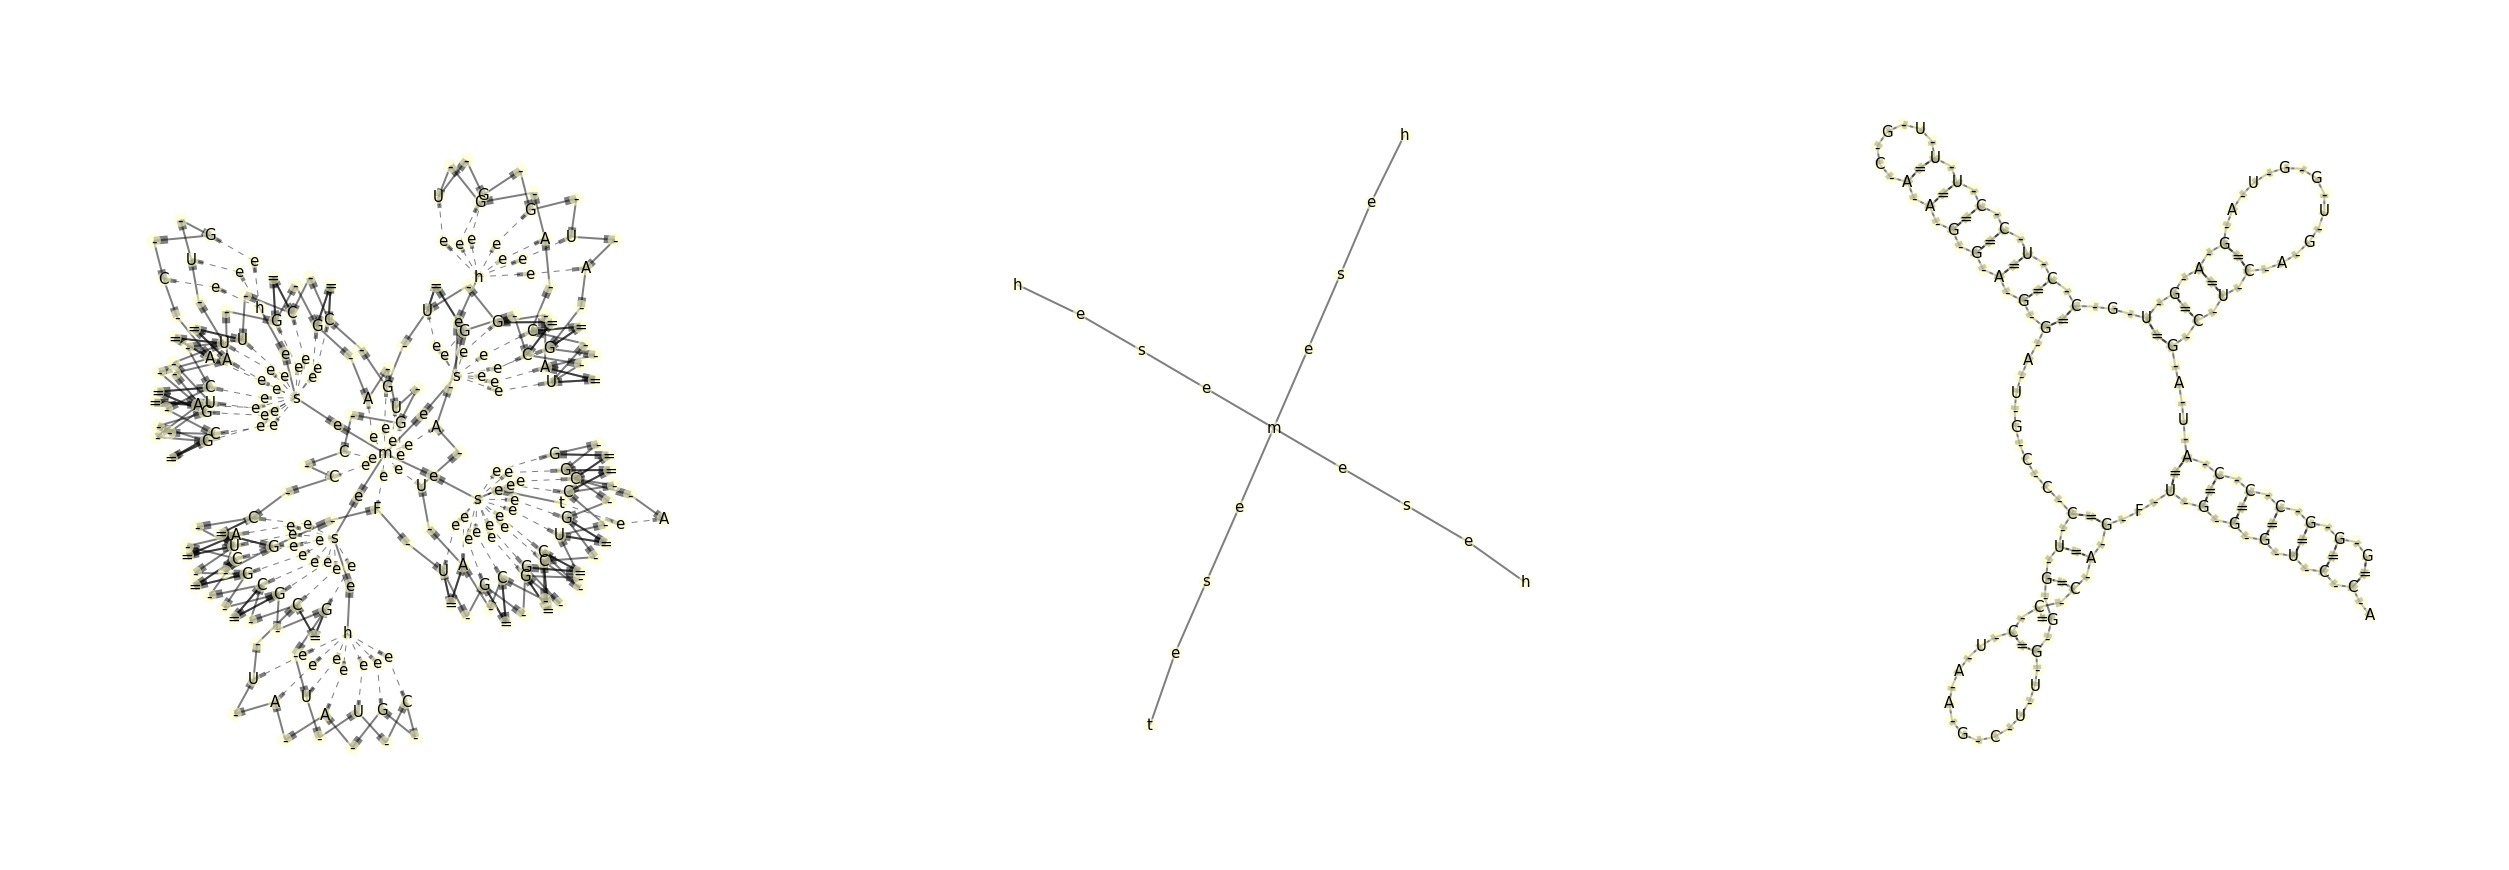

grammar example 1


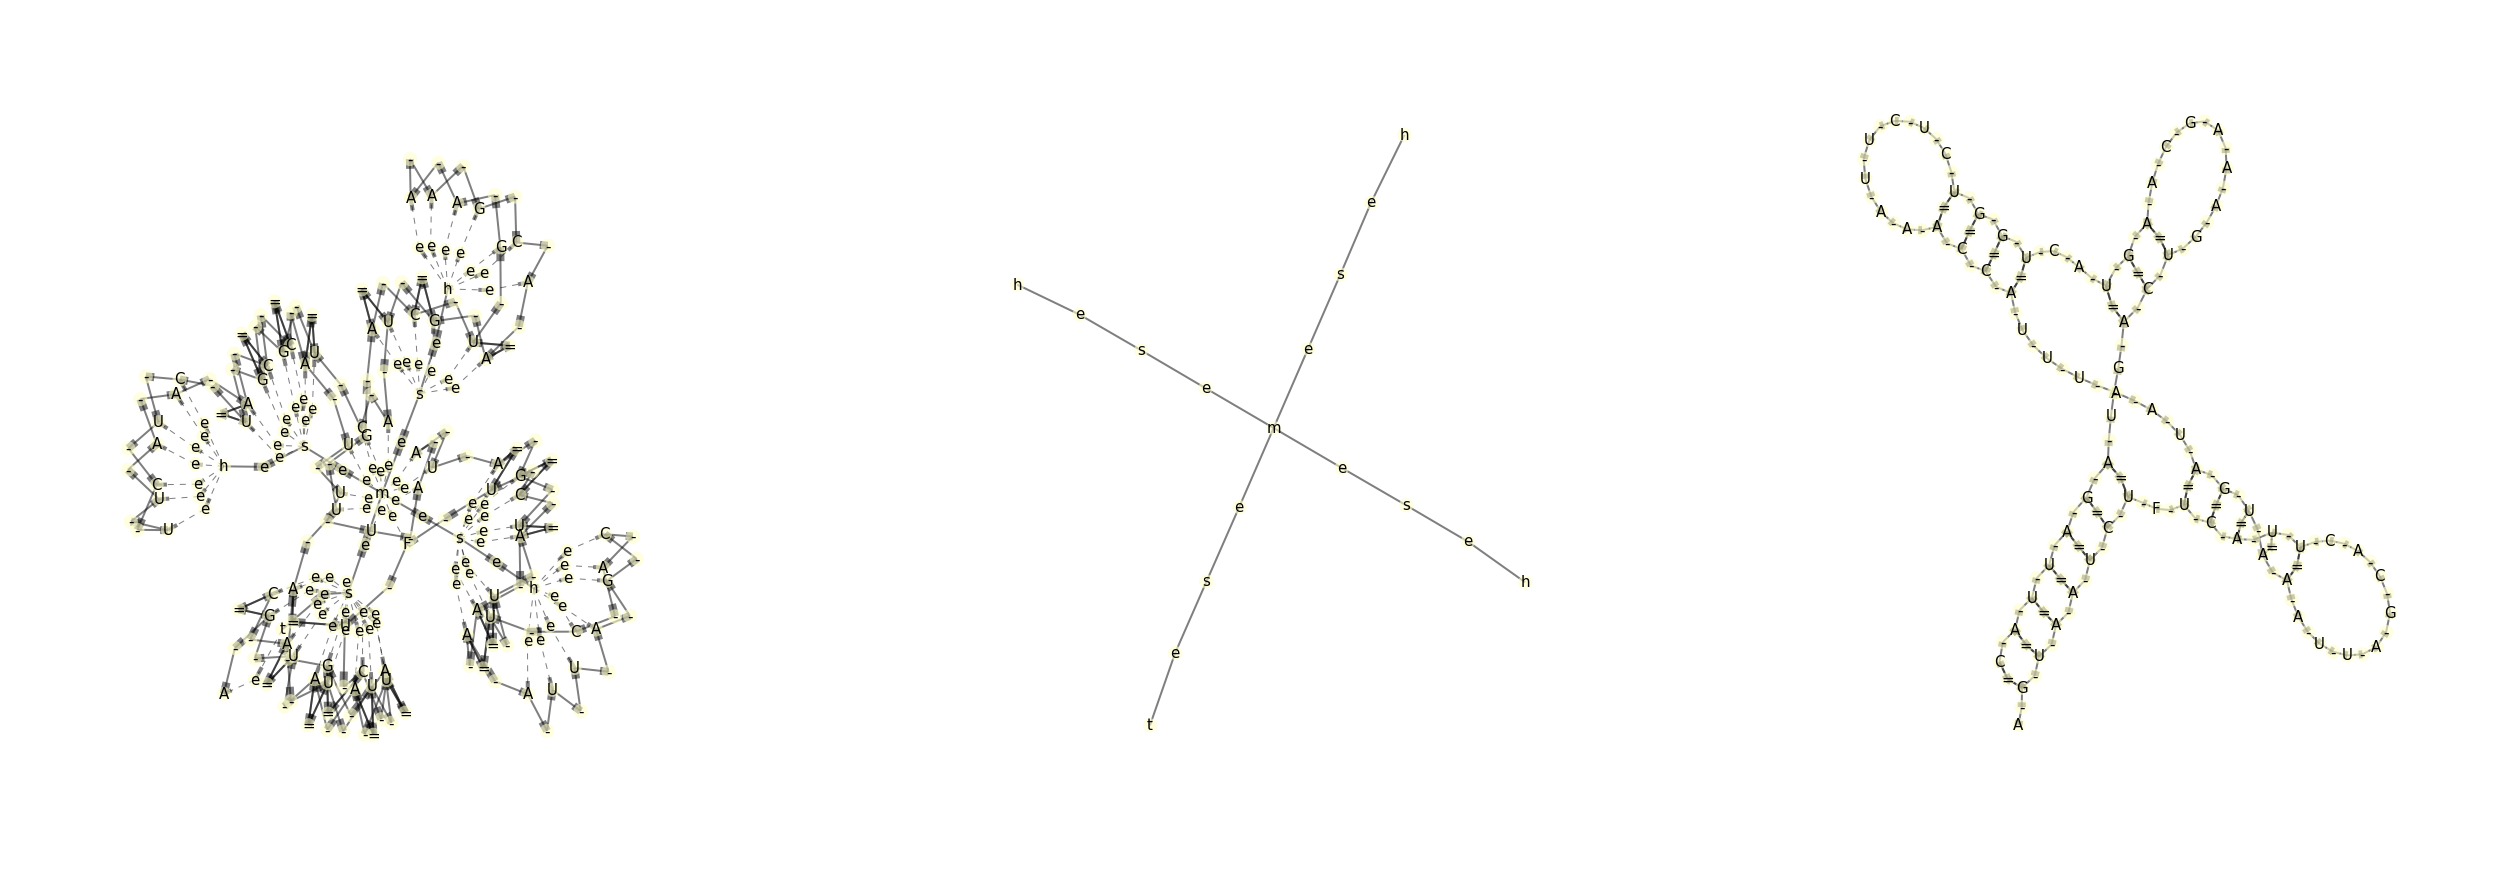

grammar example 2


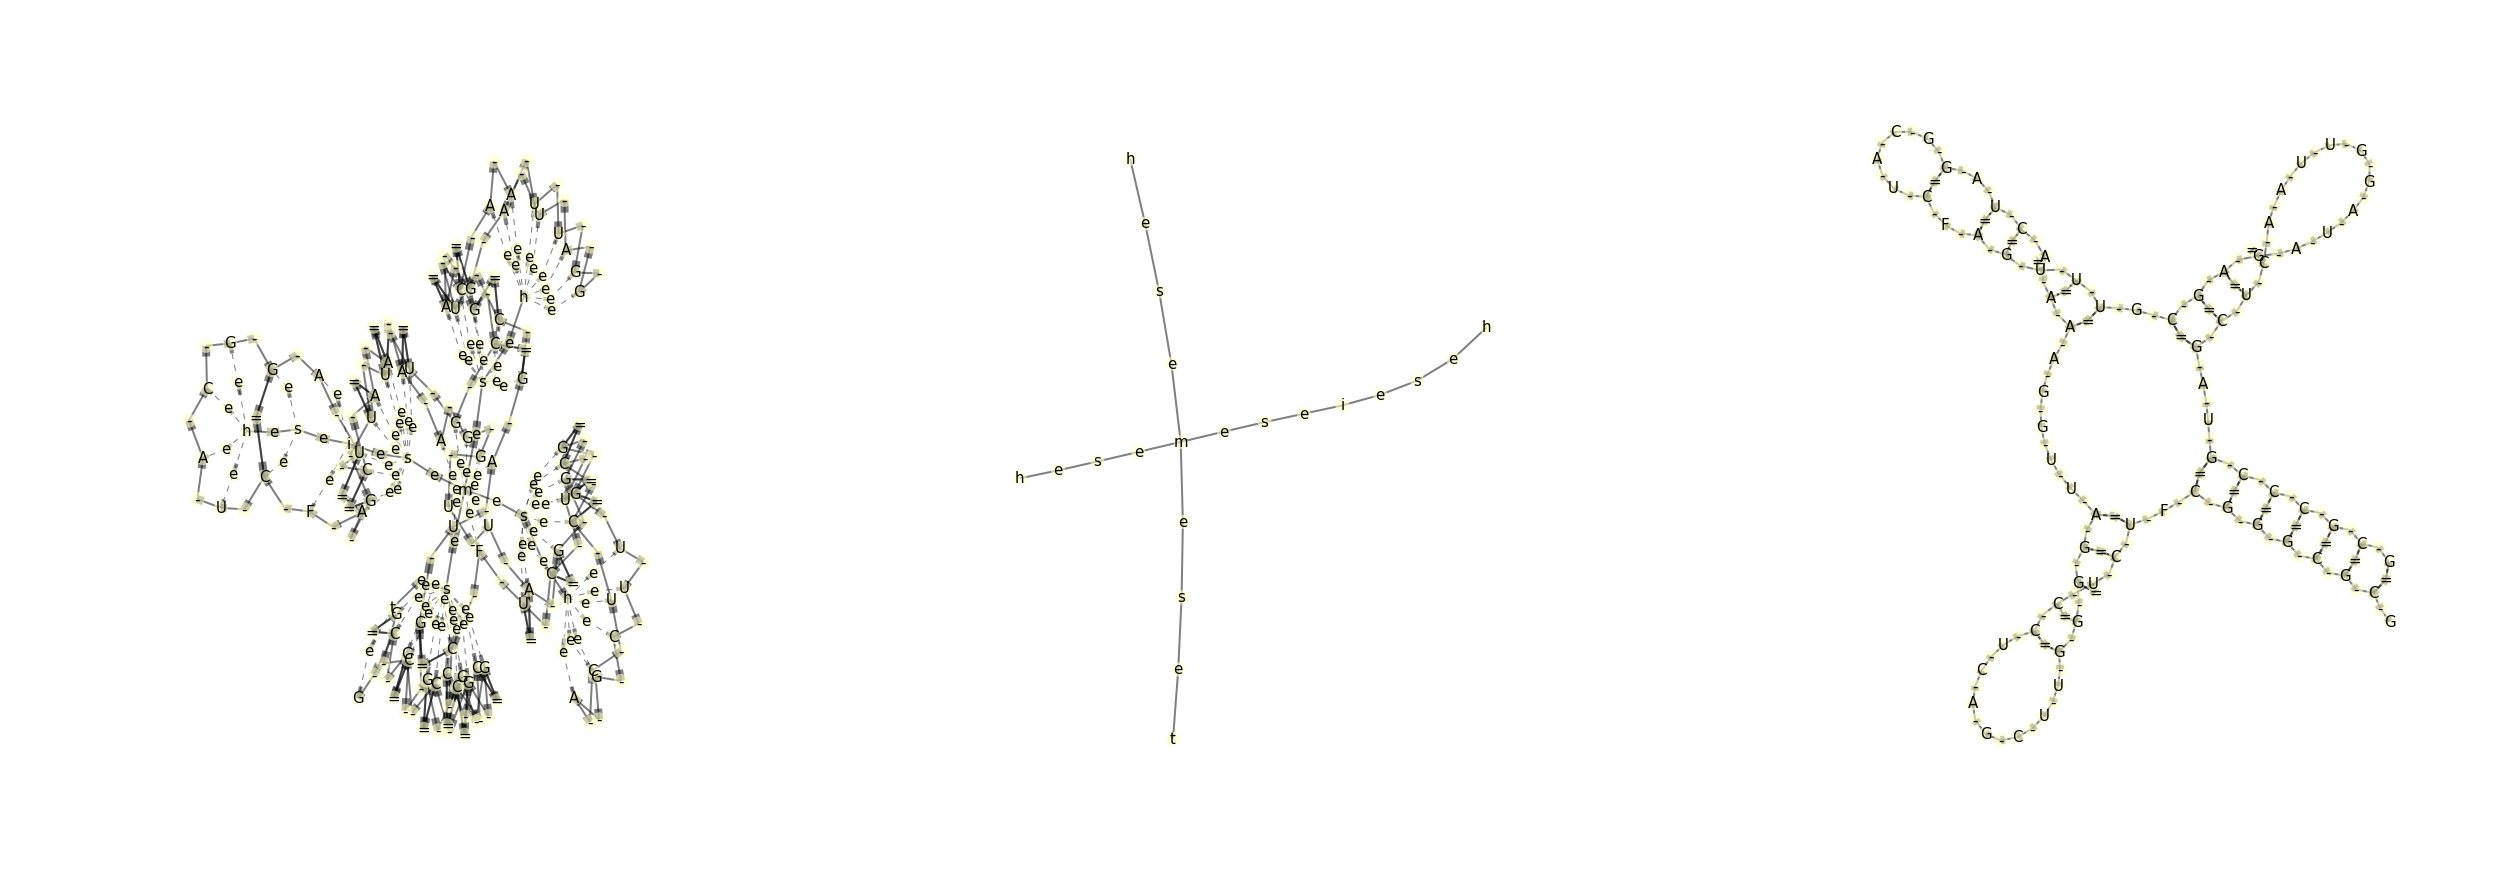

DEMONSTRATING EXTRACTION


In [4]:
'''TESTING EXTRACTION AND GRAPHMANAGER'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.RNA as rna
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer




vectorizer=Vectorizer()
pp=rna.PreProcessor()
pp.fit(get_sequences_with_names(),vectorizer)
graphmanagers=pp.transform(get_sequences()[:4])

print 'DEMONSTRATING GRAPH MANAGER'

for i in range(3):
    print 'grammar example %d' % i
    gm=graphmanagers[i]
    g=gm.graph(nested=True)
    #print g.nodes(data=True)
    #g.node[0].pop('weight')
    vec=vectorizer.transform_single(g)
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)


print 'DEMONSTRATING EXTRACTION'  
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
argz=(gm,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)
cips=gm.all_core_interface_pairs(thickness_list=thickness_list,radius_list=radius_list,hash_bitmask=2**20-1)
for ciplist in cips:
    for cip in ciplist:
        pass 
        #draw.graphlearn([cip.graph,cip.abstract_view], size=4, contract=False)
    
#g=gm.graph(nested=False)
#print 'test', g.nodes(data=True)[0][1]



In [5]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.RNA as rna
graphs = get_sequences_with_names(size=50)
sampler=rna.AbstractSampler(radius_list=[0,1],thickness_list=[2], min_cip_count=1, min_interface_count=2, preprocessor=rna.PreProcessor(), postprocessor=rna.PostProcessor())
sampler.fit(graphs,grammar_n_jobs=1,grammar_batch_size=1)
sampler.save('../tmp/rna_ubergrammar.ge')


CPU times: user 20.9 s, sys: 1.66 s, total: 22.5 s
Wall time: 32.7 s


interface id: 192835 [36 options]


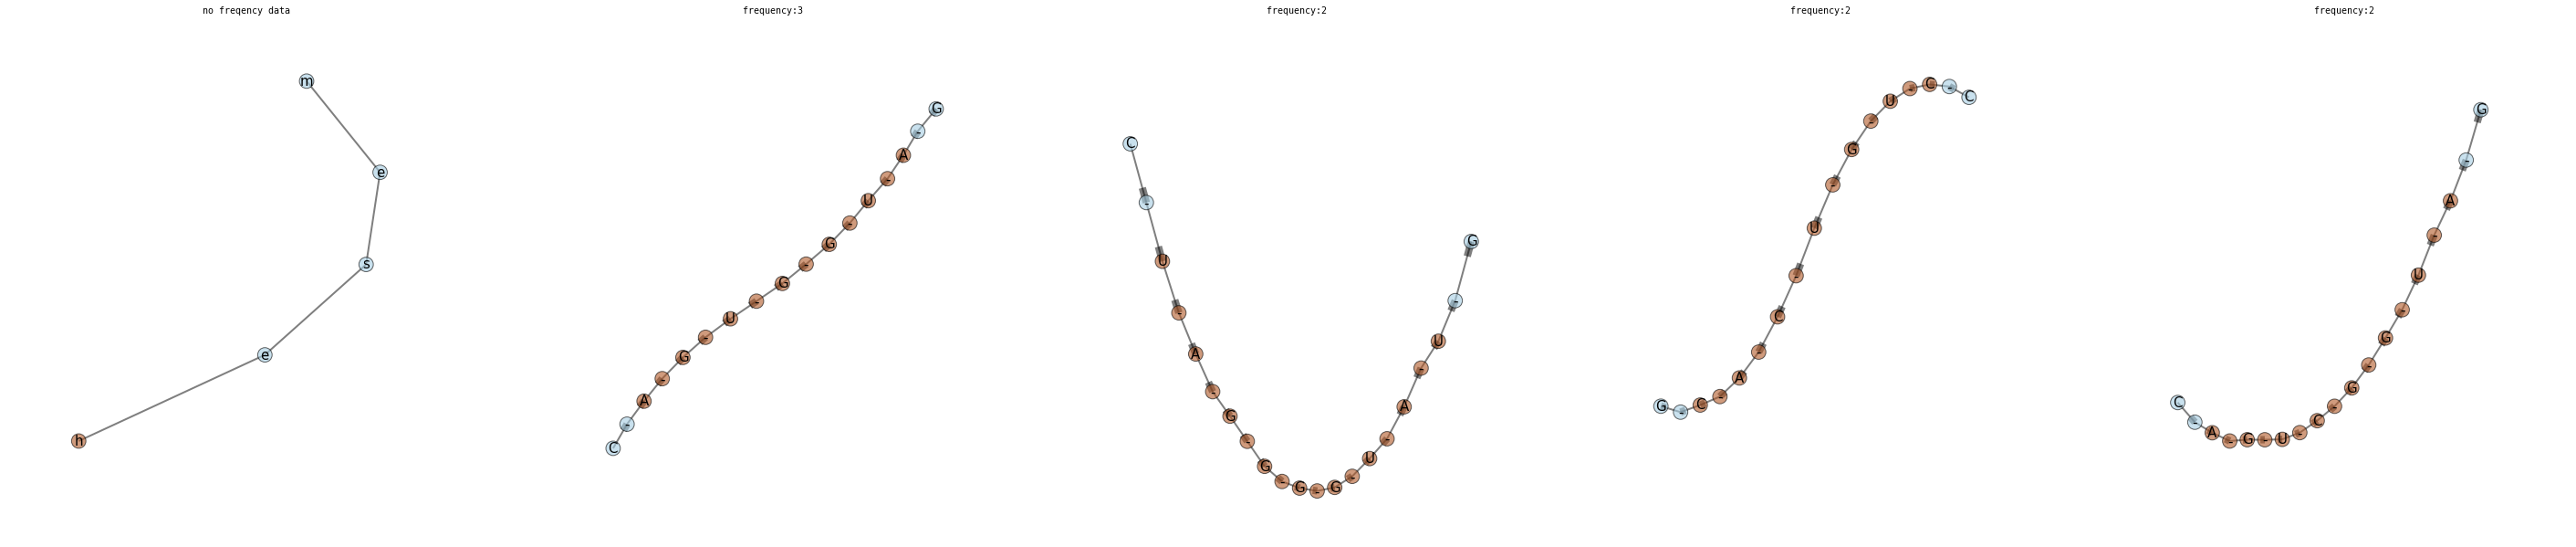

interface id: 355475 [32 options]


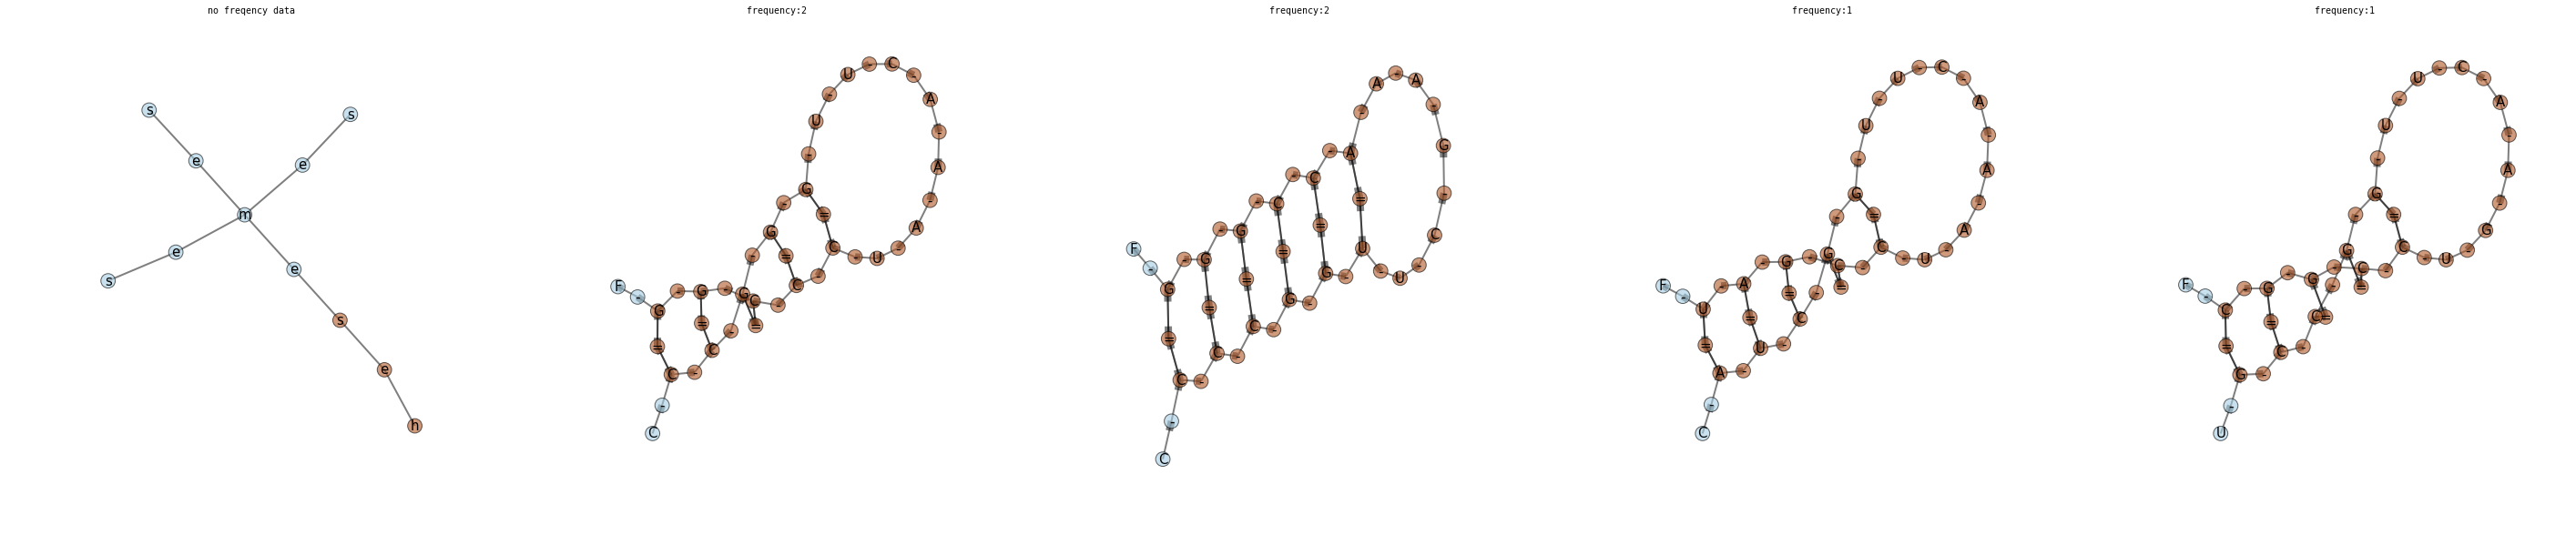

interface id: 353053 [31 options]


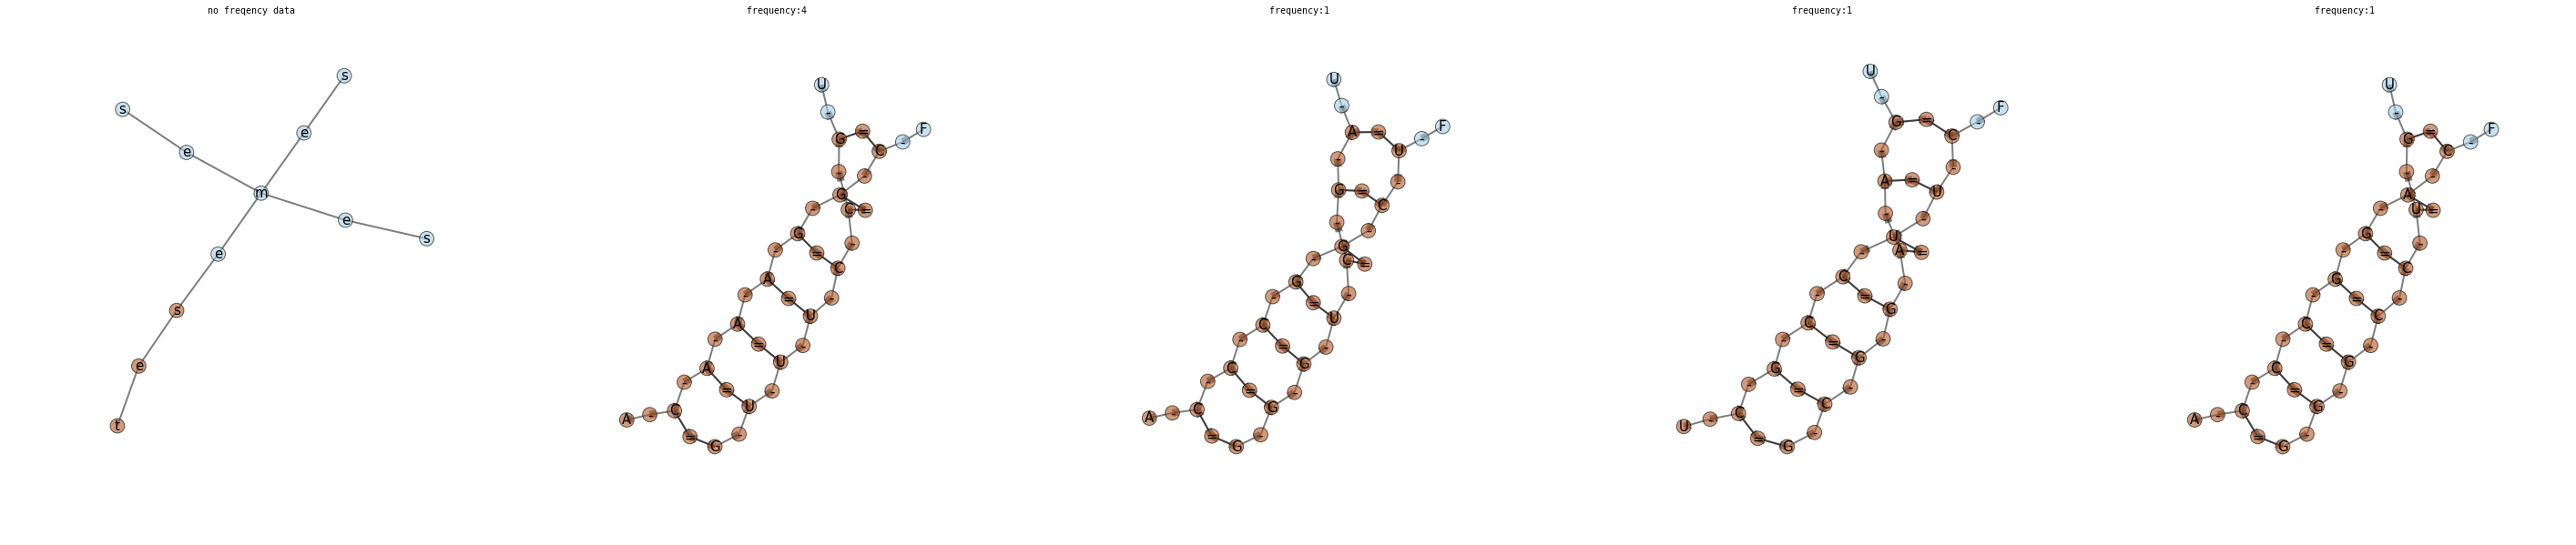

interface id: 733955 [23 options]


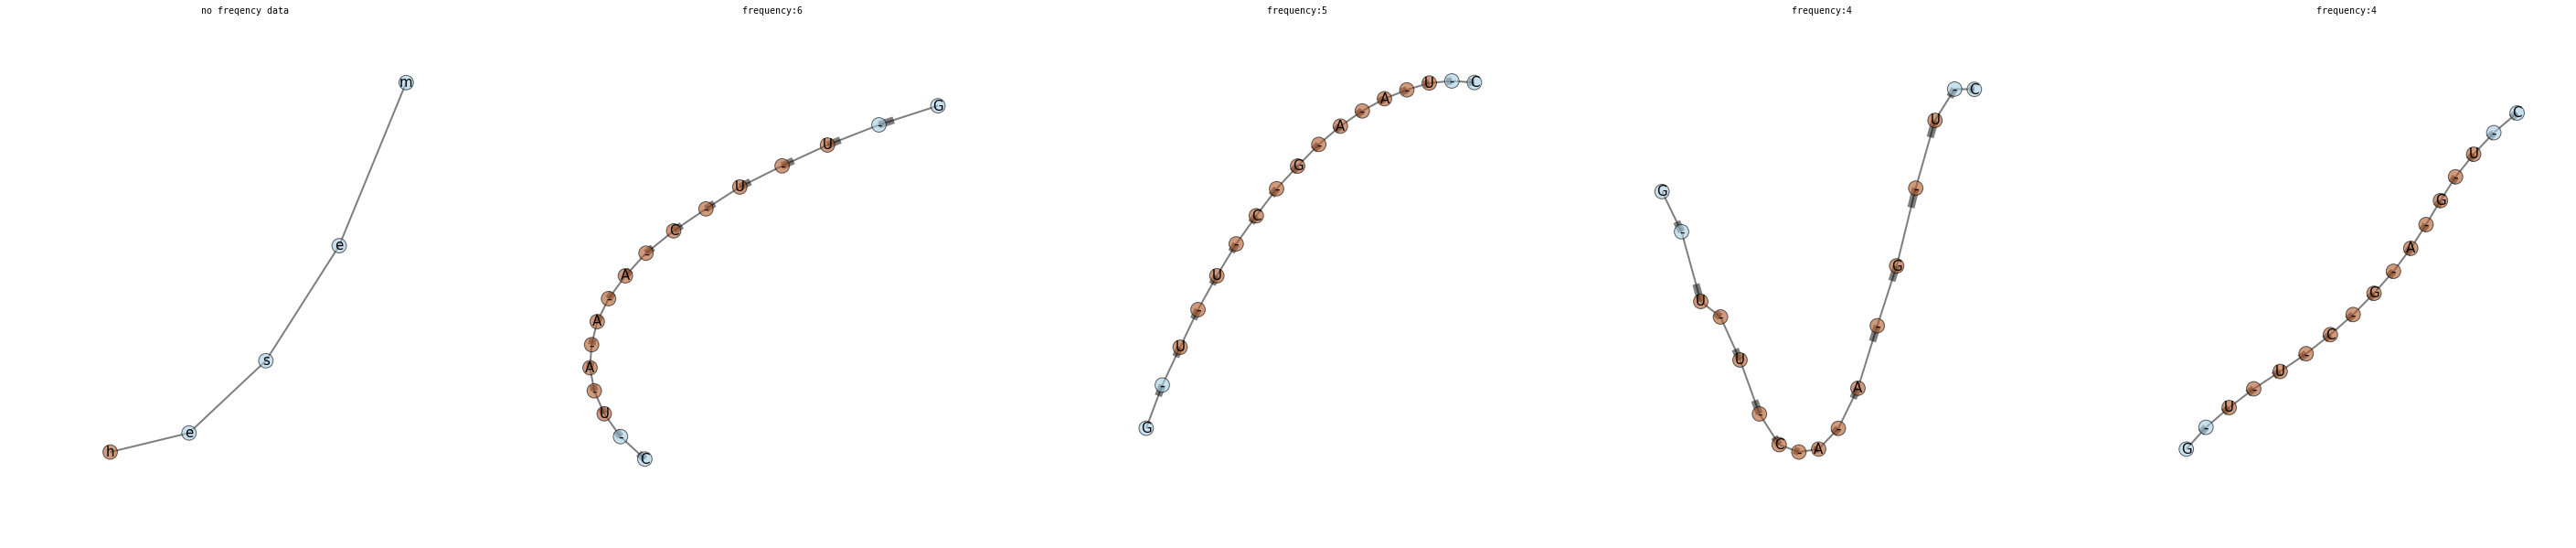

interface id: 53692 [22 options]


In [6]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=6, size=10, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=250, abstract_interface=True)

    

Graph id: 35


Graph id: 36


Graph id: 37


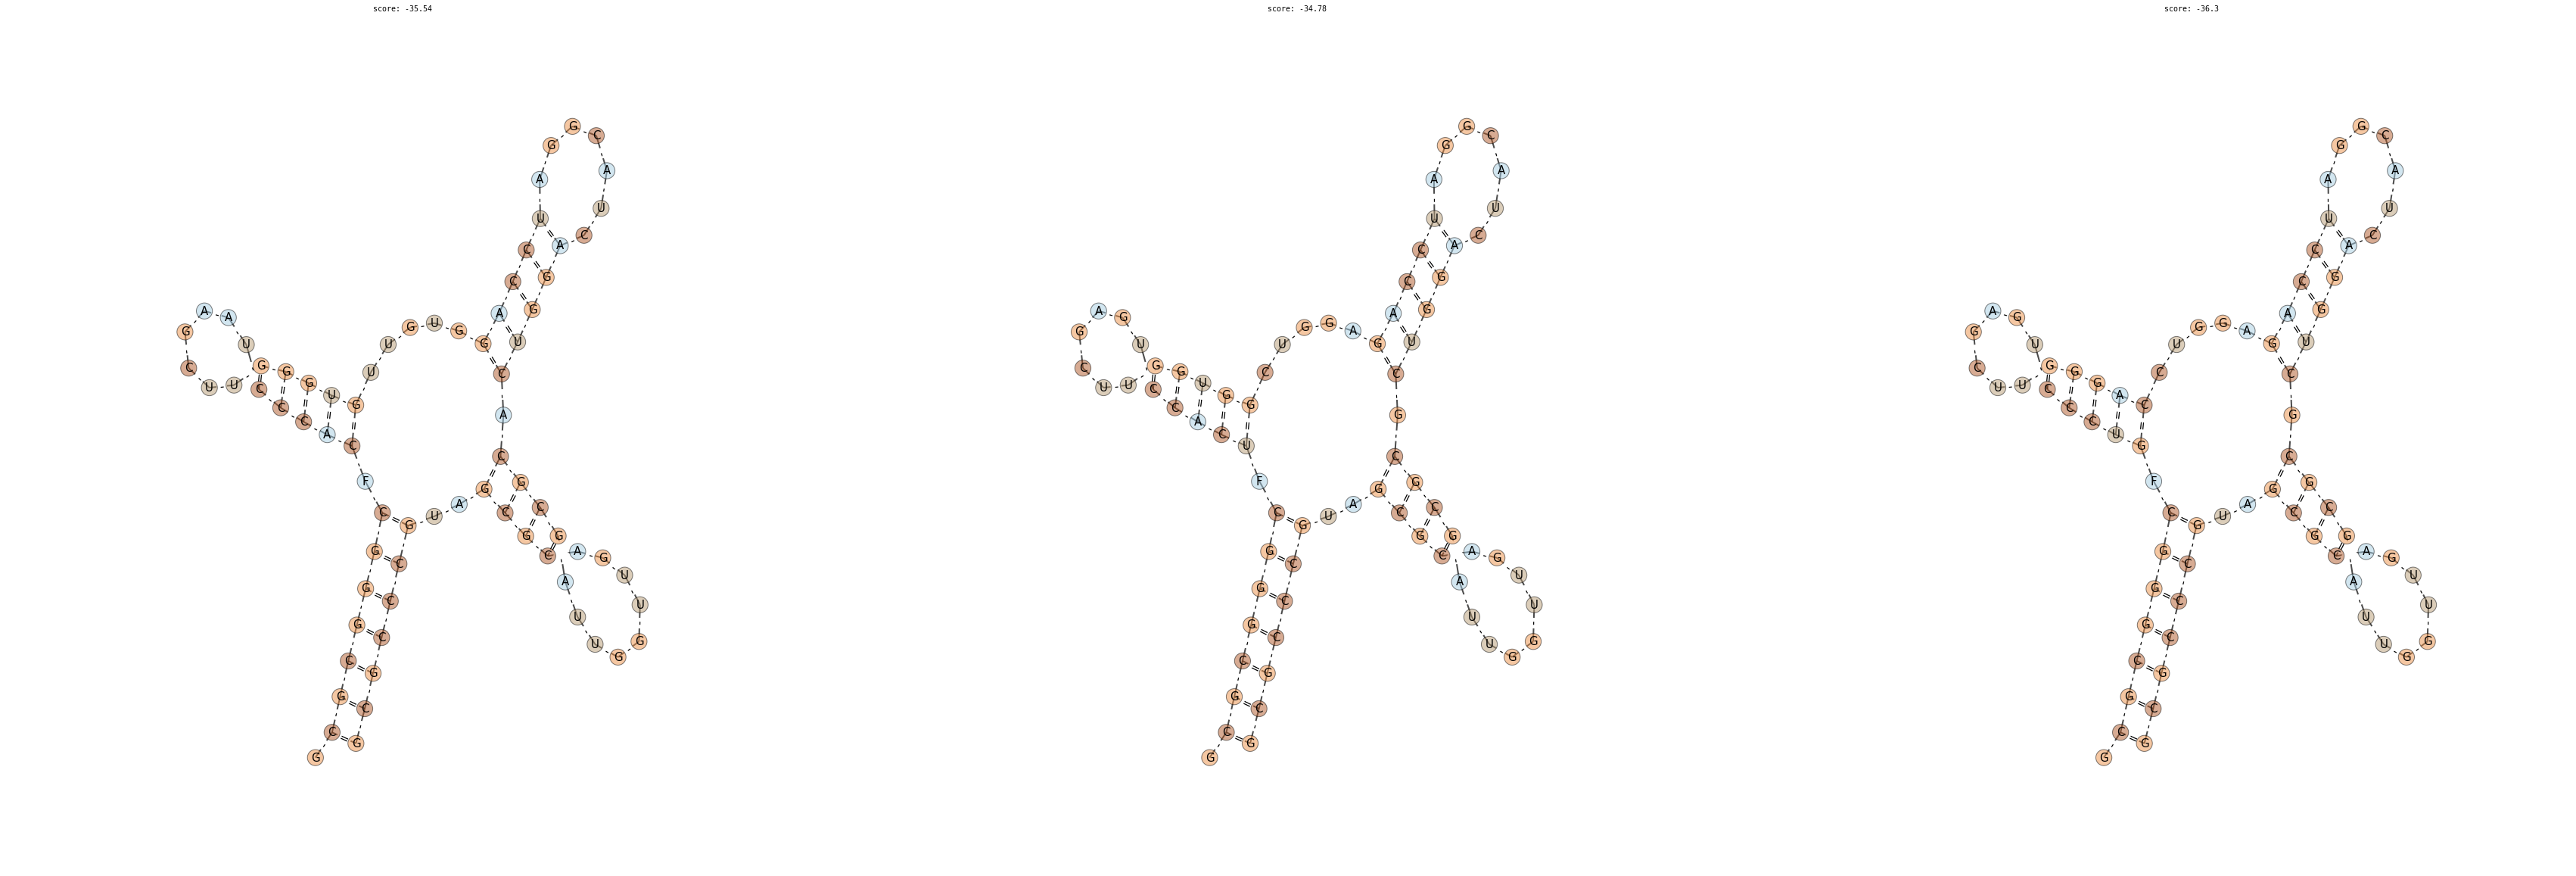

Graph id: 38


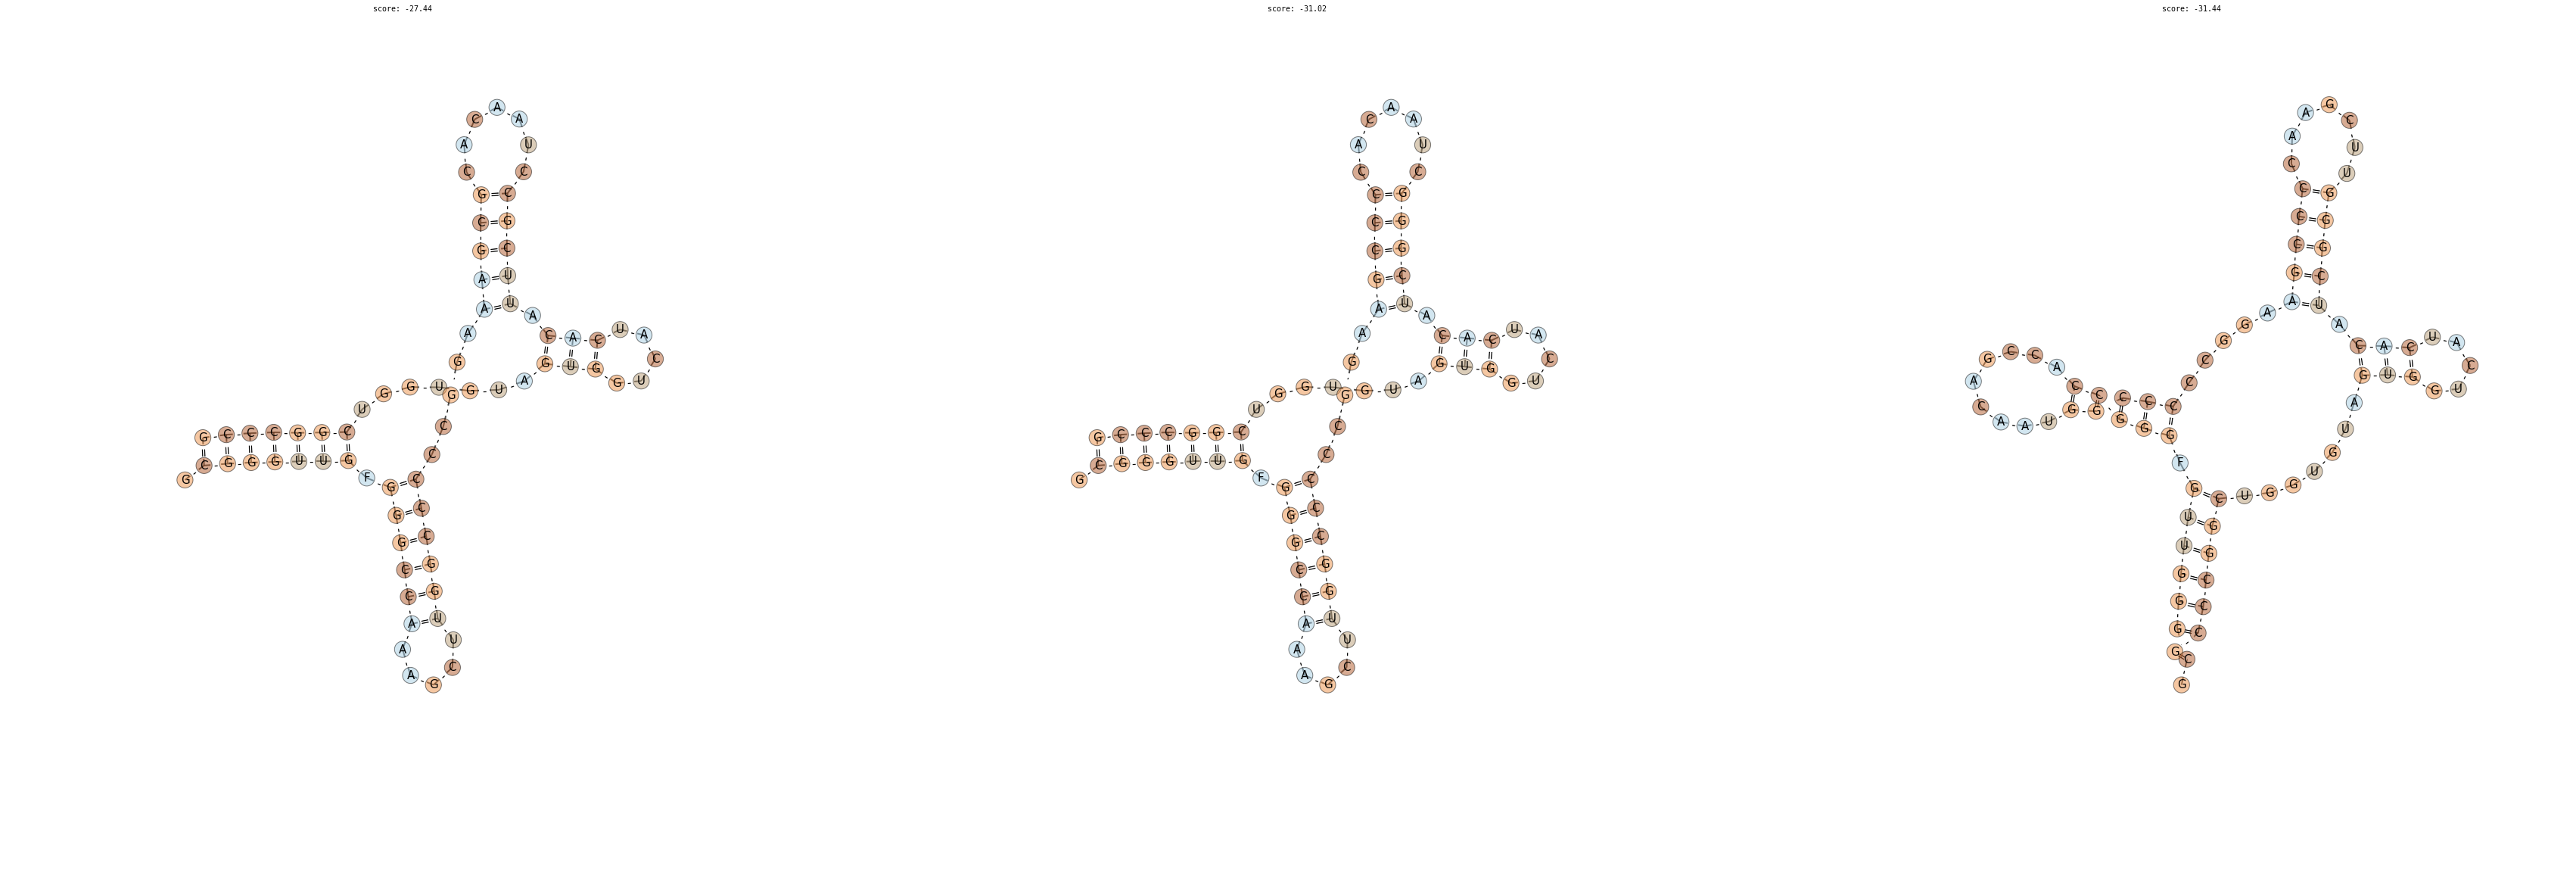

Graph id: 39


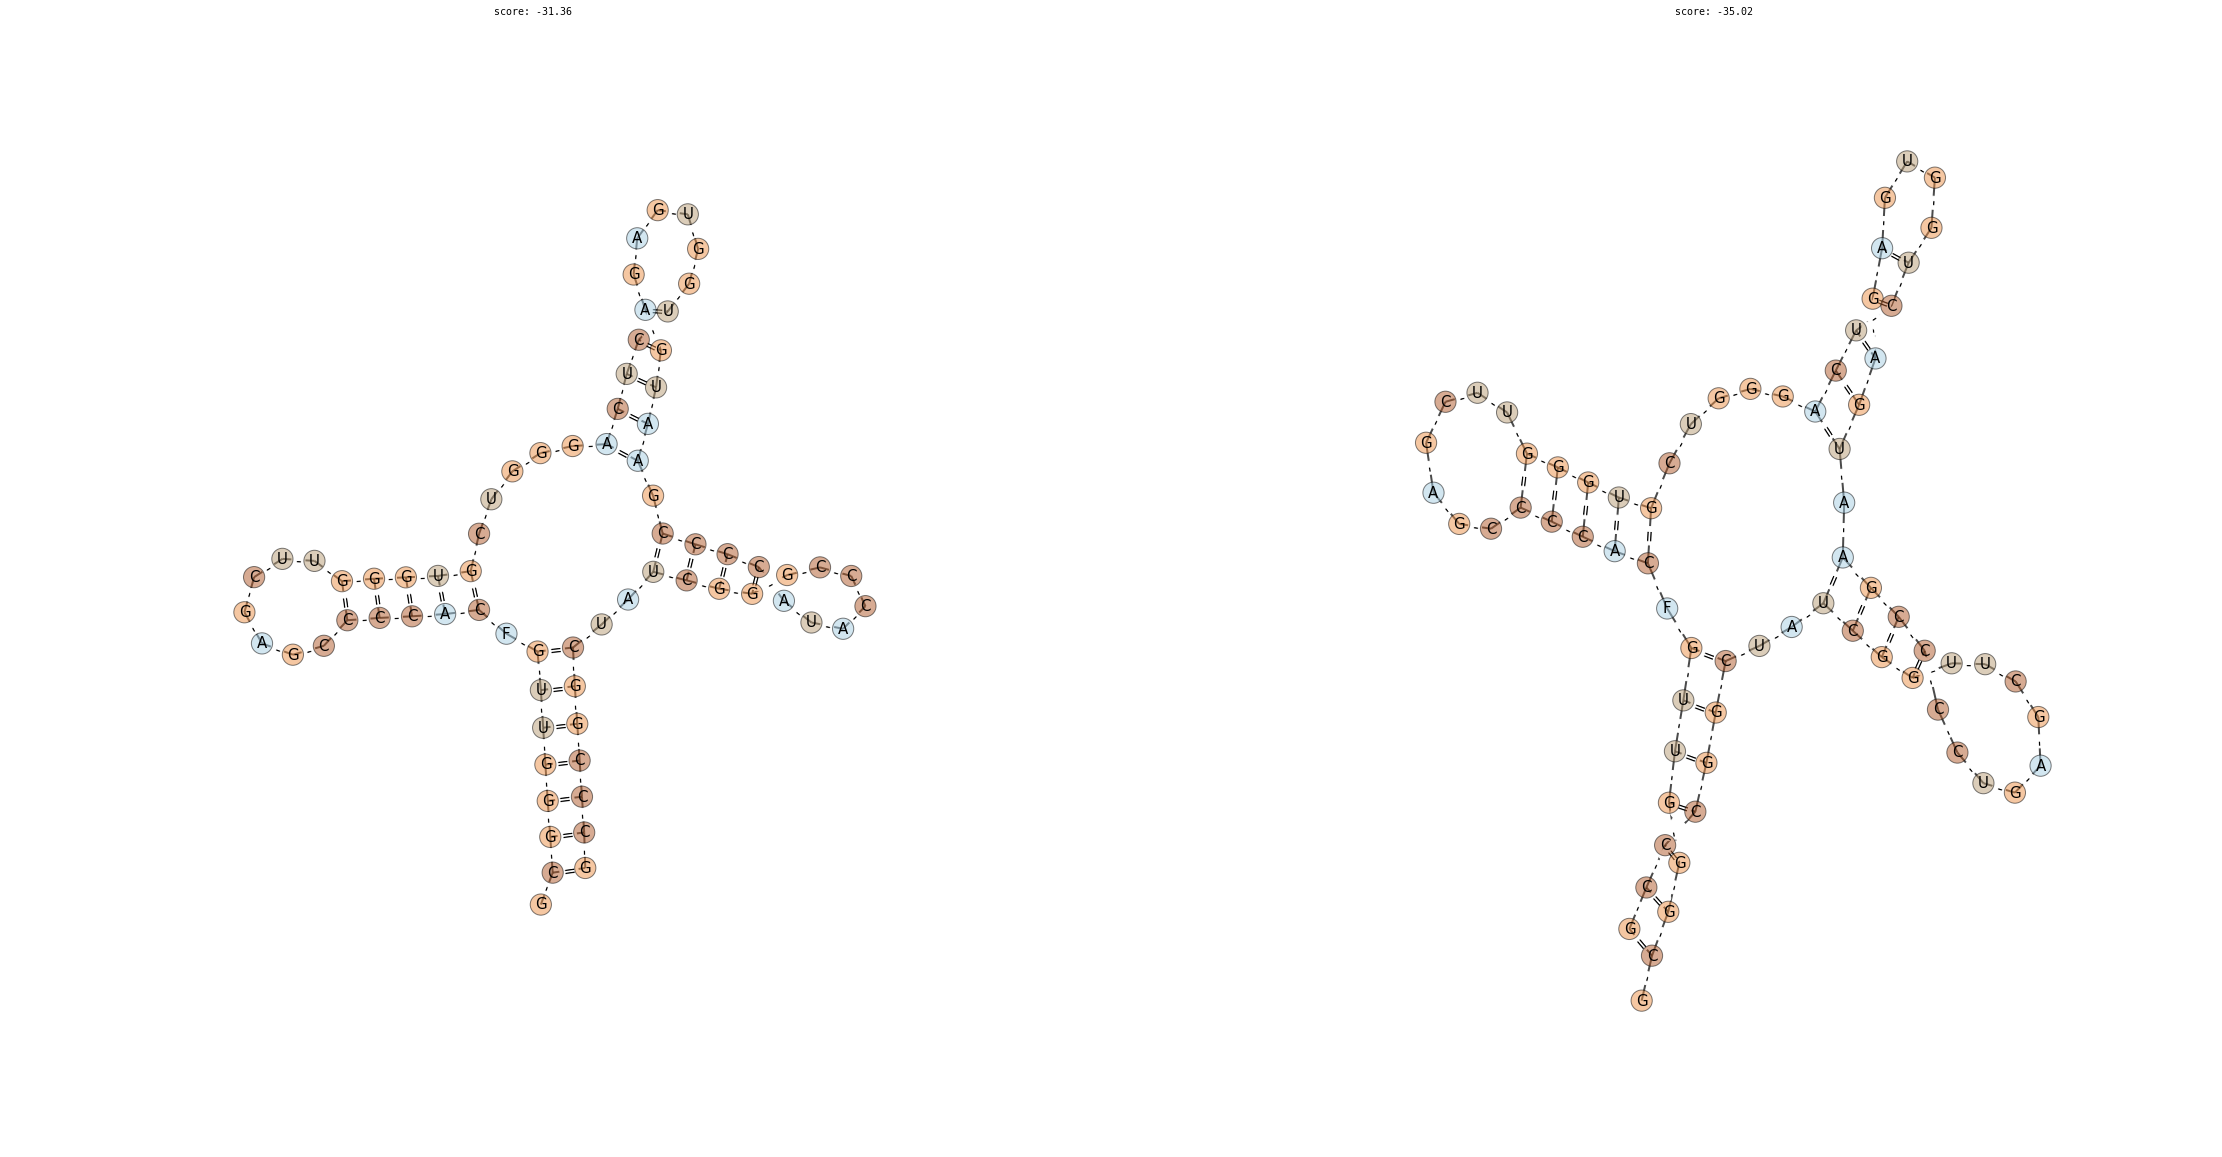

Graph id: 40


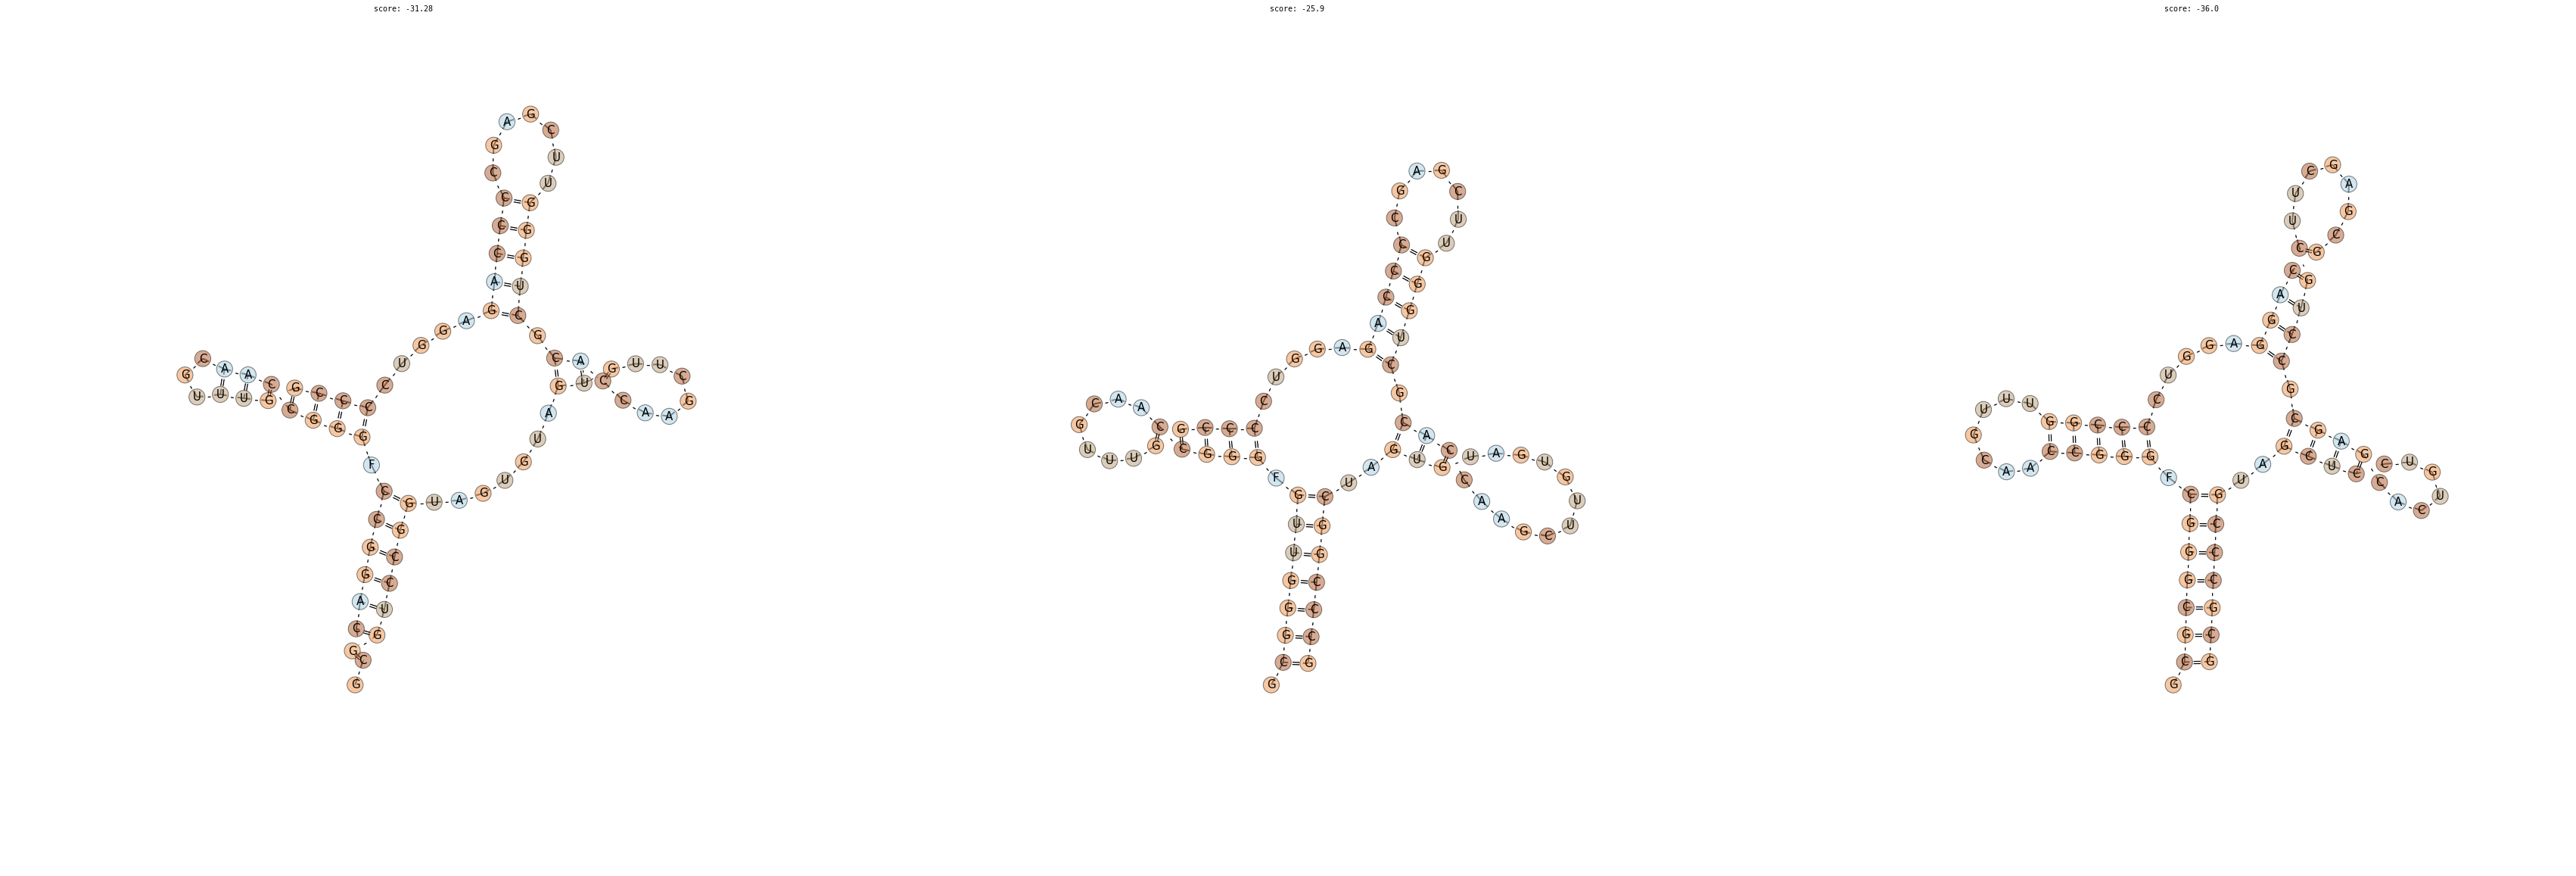

CPU times: user 56.6 s, sys: 4.98 s, total: 1min 1s
Wall time: 1min 13s


In [7]:
%%time
'''
Rna sampling
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.RNA as rna
from graphlearn.graphlearn import Sampler as GLS
import itertools
#sampler=GLS(radius_list=[0,1],thickness_list=[1], min_cip_count=1, min_interface_count=2, graphwrapper=RW.GraphWrapper(base_thickness_list=[2]))
#sampler.load('tmp/rna_ubergrammar.ge')


graphs = get_graphs()
id_start=35
id_end=id_start+6
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50

graphs = sampler.sample(graphs,
                        n_samples=3,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.1,
                        max_size_diff=10,
                        select_cip_max_tries=50,
                        keep_duplicates=False,
                        omit_seed=True,
                        backtrack=5,
                        monitor=True)


from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
sequences=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    sequences.append(sampler.monitors[i].sampling_info['notes'])
    
    path_graphs = colorize(graphlist,
                           output_attribute = 'color_level', 
                           labels = ['A','U','G','C'])
    path_graphs= list(path_graphs)
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=3, size=20, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label',
                          headlinehook= draw.get_energy_of_graph
                          )


In [8]:
'''
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()
    
'''
    
    

"\n%matplotlib inline\nfrom itertools import islice\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nstep=1\nnum_graphs_per_plot=3\nnum_plots=np.ceil([len(scores)/num_graphs_per_plot])\nfor i in range(num_plots):\n    plt.figure(figsize=(10,5))\n    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):\n        data = list(islice(score,None, None, step))\n        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))\n    plt.legend(loc='lower right')\n    plt.grid()\n    plt.ylim(-0.1,1.1)\n    plt.show()\n    \n"

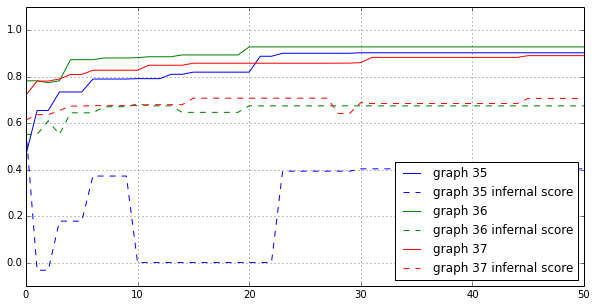

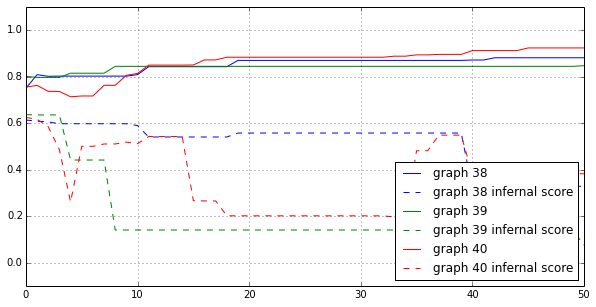

In [10]:
'''
draw the score history for each of the graphs
'''
colors=['b','g','r','c','m','y','k','w']

%matplotlib inline
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data,ls='-',color=colors[j], label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        
        # okok now we need to add the infernal evaluation
        seqs=sequences[i*num_graphs_per_plot+j]
        seqs=seqs.split('n')
        
        # SEQUENCES STILL CONTAIN F, ALSO THERE ARE ERRORMESSAGES AT THE END OF INFO
        #seqs=seqs[:-1]
    
        #print seqs
        data2= rna.infernal_checker(seqs,cmfile='../rf00005.cm')
        #print data2,seqs
        plt.plot(data2,ls='--',color=colors[j], label='graph %d infernal score'%(j+i*num_graphs_per_plot+id_start))
    
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

In [11]:

import networkx as nx
import graphlearn.utils.draw as draw
from eden.graph import Vectorizer

v=Vectorizer()
def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

g=getpathgraph("ABC")

g= v._edge_to_vertex_transform(g)

draw.graphlearn_draw(g,contract=False,show_direction=True)

g2=nx.DiGraph(g)
#draw.display(g2,contract=False,vertex_label='id')

for n,d in g2.nodes(data=True):
    if 'edge' in d:
        if d['label']=='.':
            ns=g2.neighbors(n)
            g2.remove_edge(ns[1],n)
            g2.remove_edge(n,ns[0])
          
       
#g2 = g2.to_undirected()
draw.graphlearn(g2,contract=False,vertex_label='id',show_direction=True)
g2.edges()
for n in g2.nodes():
    print n,g2.neighbors(n)
print isinstance(g2, nx.DiGraph) 

AttributeError: 'module' object has no attribute 'graphlearn_draw'

In [ ]:
g2.edges(0,data=True)

In [ ]:
asd = g2.subgraph(range(2)).copy()

In [ ]:
class A(object):
    def __init__(self,a=123):
        self.a=a
        
        
class B(A):
    def __init__(self,b=122):
        super(B,self).__init__(b)
        
        

class C(A):
    def __init__(self,c=121):
        super(C,self).__init__(c)
        
        
c=C()
c.a
        
        
        
    
    

In [ ]:
# testin cycle stuff
import networkx as nx
import graphlearn.utils.draw as draw
import graphlearn.feasibility as feas
from eden.graph import Vectorizer
v=Vectorizer()
%matplotlib inline


def find_all_cycles(G, source=None, cycle_length_limit=None):
    """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
    types which work with min() and > ."""
    if source is None:
        # produce edges for all components
        nodes=[i[0] for i in nx.connected_components(G)]
    else:
        # produce edges for components with source
        nodes=[source]
    # extra variables for cycle detection:
    cycle_stack = []
    output_cycles = set()
    
    def get_hashable_cycle(cycle):
        """cycle as a tuple in a deterministic order."""
        m = min(cycle)
        mi = cycle.index(m)
        mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
        if cycle[mi-1] > cycle[mi_plus_1]:
            result = cycle[mi:] + cycle[:mi]
        else:
            result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
        return tuple(result)
    
    for start in nodes:
        if start in cycle_stack:
            continue
        cycle_stack.append(start)
        
        stack = [(start,iter(G[start]))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                
                if child not in cycle_stack:
                    cycle_stack.append(child)
                    stack.append((child,iter(G[child])))
                else:
                    i = cycle_stack.index(child)
                    if i < len(cycle_stack) - 2: 
                      output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                
            except StopIteration:
                stack.pop()
                cycle_stack.pop()
    
    return [list(i) for i in output_cycles]


def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

#g=getpathgraph("ABC")

#g= v._edge_to_vertex_transform(g)

#draw.graphlearn_draw(g,contract=False,show_direction=True)


#draw.display(g2,contract=False,vertex_label='id')

g=nx.cycle_graph(10)
g.add_edge(2,7)
g.add_edge(10,0)

draw.graphlearn_draw(g, vertex_label='id')


feas.rooted_problem_cycle(g,2,4)

In [ ]:
print g.graph

In [ ]:
stru,stri='(.((...))...)', 'aFaaaaaaaaaaa'



def pairs(s):
    "give me a bond dict"
    unpaired=[]
    pairs={}
    for i,c in enumerate(s):
        if c=='(':
            unpaired.append(i)
        if c==')':
            partner=unpaired.pop()
            pairs[i]=partner
            pairs[partner]=i
    return pairs



def fix_structure( stru,stri ):
    '''
    the problem is to check every (( and )) . 
    if the bonding partners are not next to each other we know that we need to act.
    '''
    p=pairs(stru)
    lastchar="."
    problems=[]
    for i,c in enumerate(stru):
        # checking for )) and ((
        if c==lastchar and c!='.':
            if abs(p[i]-p[i-1])!=1: #the partners are not next to each other
                problems.append(i)
        # )( provlem
        elif c=='(':
            if lastchar==')':
                problems.append(i)          
        lastchar=c
            
    problems.sort(reverse=True)
    for i in problems:
        stru=stru[:i]+'.'+stru[i:]
        stri=stri[:i]+'F'+stri[i:]

    return stru,stri
    

    
fix_structure(stru,stri)






In [ ]:
l=[[4,5],[3,4]]
l.sort()
l


In [ ]:
import graphlearn.abstract_graphs.RnaWrap as RW
from eden.converter.fasta import fasta_to_sequence   
seq = [ b for (a,b) in fasta_to_sequence("RF00005.fa") ] 
        
folder=RW.NearestNeighborFolding(seq,4)

folder.fold("GGGGCCUUAGCUCAGCUGGGAGAGCGCCUGCUUUGCACGCAGGAGGUCAGCGGUUCGAUGGCGCUAGGCUCCA")
a,b=folder.call_folder()
    


In [ ]:
import textwrap
textwrap.wrap("asdasdasdasdasdasd", width=3)

In [ ]:
print a,b

In [ ]:
s="asdasdasdasd"
s.get(z,123)

In [ ]:
z=[1,2,3]
z.reverse()
z

In [ ]:
def lol():
    print "a"
    return False

if True or lol():
    pass